# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [480]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [ ]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [ ]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### FSC

In [ ]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

In [ ]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

In [ ]:
plt.plot(res, fsc)

In [ ]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [ ]:
fsc

In [ ]:
fsc[10]

In [ ]:
fsc[11]

In [ ]:
res_angs[10]

In [ ]:
res_angs[11]

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [552]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

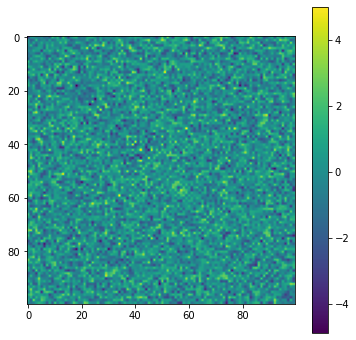

In [553]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [554]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [555]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [556]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [557]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

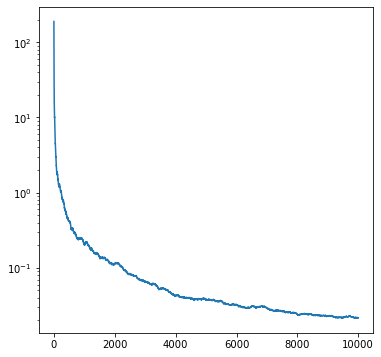

In [558]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [559]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [560]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [561]:
f(x0)

DeviceArray(0., dtype=float64)

In [562]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [563]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

1.35469651222229
0.6434576511383057


DeviceArray(0., dtype=float64)

#### Toy problem

Text(0.5, 1.0, 'Condition number = 326.166125611872')

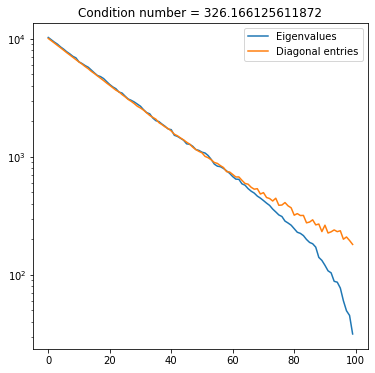

In [564]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))

Adiag = jnp.flip(jnp.logspace(1,2,n))
np.fill_diagonal(A, Adiag)

A = A.T @ A

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort( evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.abs(A.T - A)) == 0)
assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals)
plt.semilogy(jnp.diag(A))
plt.legend(["Eigenvalues", "Diagonal entries"])
plt.title(f"Condition number = {evals[0]/evals[n-1]}")

In [729]:
sig_noise = 1
lam = 0.1

b = A @ x_gt #+ np.random.normal(size=(n,)) * sig_noise

F = lambda x : jnp.mean((A @ x - b)**2) #+ lam * jnp.mean(x**2)
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.grad(F)
hessianF = jax.hessian(F)

hvpF = lambda x, v : hvp(F, (x,), (v,))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 11335342.64774272
f(x_gt) = 0.0
gradF(x_gt) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
hessianF(x_gt) = [[ 2.05928913e+06 -8.77704015e+03  1.67111939e+04 ... -2.33798021e+04
   1.08962949e+03 -1.96863355e+04]
 [-8.77704015e+03  1.88194682e+06  4.31507978e+04 ... -3.62070724e+04
   2.81963165e+04 -1.37202695e+04]
 [ 1.67111939e+04  4.31507978e+04  1.71921460e+06 ... -1.66425561e+04
   1.73256581e+04  9.96639217e+03]
 ...
 [-2.33798021e+04 -3.62070724e+04 -1.66425561e+04 ...  6.40743174e+03
  -7.56985702e+02  6.05919181e+02]
 [ 1.08962949e+03  2.81963165e+04  1.73256581e+04 ... -7.56985702e+02
   4.83702956e+03  5.07061418e+01]
 [-1.96863355e+04 -1.37202695e+04  9.96639217e+03 ...  6.05919181e+02
   5.07061418e+01

In [730]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [731]:
N_iter = 5000
eta = 0.0000005 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 47859.24288184954
Iter 400: loss = 13399.198620480018
Iter 600: loss = 7146.547315901742
Iter 800: loss = 4806.448770667898
Iter 1000: loss = 3547.8439034465246
Iter 1200: loss = 2765.0174499083255
Iter 1400: loss = 2238.341537030555
Iter 1600: loss = 1863.8103738771572
Iter 1800: loss = 1585.8655889227603
Iter 2000: loss = 1372.5654408615671
Iter 2200: loss = 1204.4553428247793
Iter 2400: loss = 1069.0864891881756
Iter 2600: loss = 958.1450735586665
Iter 2800: loss = 865.8713571171154
Iter 3000: loss = 788.1489432201271
Iter 3200: loss = 721.9578976677055
Iter 3400: loss = 665.0335352656011
Iter 3600: loss = 615.6459458701827
Iter 3800: loss = 572.4529656345399
Iter 4000: loss = 534.3993290106386
Iter 4200: loss = 500.64575959952646
Iter 4400: loss = 470.51801947469164
Iter 4600: loss = 443.4696030641538
Iter 4800: loss = 419.0539715237622
Iter 5000: loss = 396.903592490361


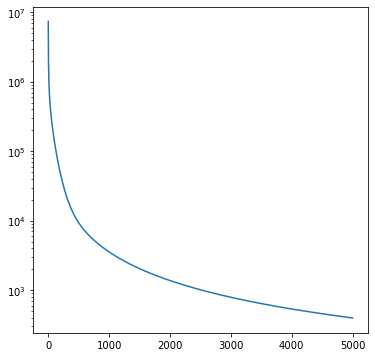

In [732]:
plt.semilogy(loss_gd)

In [733]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 2.2719029587439038e-20
Iter 2: loss = 4.807421854967611e-25
Iter 3: loss = 4.452638920364789e-25
Iter 4: loss = 3.094354232383732e-25
Iter 5: loss = 5.090896812448247e-25
Iter 6: loss = 4.899429542242796e-25
Iter 7: loss = 4.356430706541482e-25
Iter 8: loss = 2.9905325641919566e-25
Iter 9: loss = 2.500767324552405e-25
Iter 10: loss = 2.4783914427479924e-25


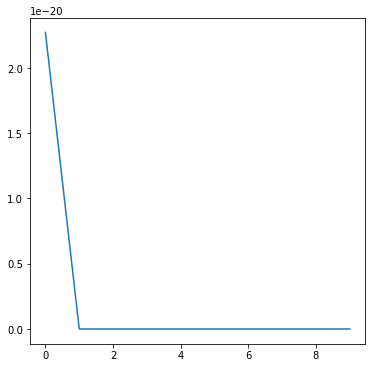

In [734]:
plt.plot(loss_n)

In [736]:
N_iter = 5000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = lambda vv : jnp.conj(gradF(vv)) + Ab

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 2677432.135699589
  cg iter 200 ||r|| = 146.38119779770258
  cg iter 400 ||r|| = 0.05544715772296489
  cg iter 600 ||r|| = 3.4925557486387617e-13
  cg iter 800 ||r|| = 1.2801023918266537e-13
  cg iter 1000 ||r|| = 9.461569846352503e-14
  cg iter 1200 ||r|| = 5.517261668721081e-14
  cg iter 1400 ||r|| = 4.954841879679845e-14
  cg iter 1600 ||r|| = 2.3674832219446607e-14
  cg iter 1800 ||r|| = 3.145788213609195e-14
  cg iter 2000 ||r|| = 2.5262367722879116e-14
  cg iter 2200 ||r|| = 2.3927162122213495e-14
  cg iter 2400 ||r|| = 2.980791782259604e-14
  cg iter 2600 ||r|| = 3.5232426923504994e-14
  cg iter 2800 ||r|| = 2.392692898616326e-14
  cg iter 3000 ||r|| = 1.2438705232520716e-14
  cg iter 3200 ||r|| = 1.7332871731075747e-14
  cg iter 3400 ||r|| = 2.306264427097961e-14
  cg iter 3600 ||r|| = 3.020659887810861e-14
  cg iter 3800 ||r|| = 1.6413040210228075e-14
  cg iter 4000 ||r|| = 2.0132089306718505e-14
  cg iter 4200 ||r|| = 2.1652862137278752e-14
  cg iter 4400 

In [737]:
F(x_cg)

DeviceArray(5.86161508e-23, dtype=float64)

#### OASIS

In [1041]:
from tqdm import tqdm 

def oasis(key, F, gradF, hvpF, w0, eta, D0, beta2, alpha, N_epoch = 20, batch_size = None, N = 1, iter_display = 1):
    """OASIS with fixed learning rate, deterministic or stochastic."""
    
    n = w0.shape[0] 
    
    if batch_size is None or batch_size == N:
        N_batch = 1
    else:
        N_batch = N/batch_size
    
    gradFw0 = gradF(w0, jnp.arange(N))
    Dhat0 = jnp.maximum(jnp.abs(D0), alpha)
                      
    invDhat0 = jnp.diag(1/Dhat0)
    w1 = w0 - eta0 * (invDhat0 @ gradFw0)

    loss_list = []
    for idx_epoch in range(1, N_epoch+1):
        if idx_epoch % iter_display == 0:
            print(f"Epoch {idx_epoch}/{N_epoch}")

        key, subkey1, subkey2 = random.split(key, 3)

        idx_batches_grad = np.array_split(random.permutation(subkey1, N), N_batch)
        idx_batches_hess = np.array_split(random.permutation(subkey2, N), N_batch)
        
        z = random.rademacher(key, (len(idx_batches_grad), n)).astype(jnp.float64)
     
        loss_epoch = []
        if idx_epoch % iter_display == 0:
            pbar = tqdm(range(len(idx_batches_grad)))
        else:
            pbar = range(len(idx_batches_grad))
        for k in pbar:

            D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvpF(w1, z[k-1], idx_batches_hess[k-1]))
            Dhat1 = jnp.maximum(jnp.abs(D1), alpha)       
            invDhat1 = jnp.diag(1/Dhat1)

            w2 = w1 - eta * (invDhat1 @ gradF(w1, idx_batches_grad[k-1]))

            w0 = w1
            w1 = w2

            loss_iter = F(w1, idx_batches_grad[k-1])
            loss_epoch.append(loss_iter)
            
            if idx_epoch % iter_display == 0:
                pbar.set_postfix(loss = f"{loss_iter : .3f}")
                
        loss_epoch = jnp.mean(jnp.array(loss_epoch))
        loss_list.append(loss_epoch)
        
        if idx_epoch % iter_display == 0:
            print(f"  Loss = {loss_epoch : .3f}")
        
    return w1, jnp.array(loss_list)


In [1077]:
def oasis_adaptive(key, F, gradF, hvpF, w0, eta0, D0, beta2, alpha, N_epoch = 20, batch_size = None, N = 1, iter_display = 1):
    """OASIS with adaptive learning rate, deterministic and stochastic."""

    n = w0.shape[0] 
    
    if batch_size is None or batch_size == N:
        N_batch = 1
    else:
        N_batch = N/batch_size
    
    gradFw0 = gradF(w0, jnp.arange(N))
    theta0 = jnp.inf
    Dhat0 = jnp.maximum(jnp.abs(D0), alpha)
                        
    invDhat0 = jnp.diag(1/Dhat0)
    w1 = w0 - eta0 * (invDhat0 @ gradFw0)
    
    gradFw1 = gradF(w1, jnp.arange(N))

    loss_list = []
    for idx_epoch in range(1, N_epoch+1):
        if idx_epoch % iter_display == 0:
            print(f"Epoch {idx_epoch}/{N_epoch}")

        key, subkey1, subkey2 = random.split(key, 3)

        idx_batches_grad = np.array_split(random.permutation(subkey1, N), N_batch)
        idx_batches_hess = np.array_split(random.permutation(subkey2, N), N_batch)
        
        z = random.rademacher(key, (len(idx_batches_grad), n)).astype(jnp.float64)
     
        loss_epoch = []
        if idx_epoch % iter_display == 0:
            pbar = tqdm(range(len(idx_batches_grad)))
        else:
            pbar = range(len(idx_batches_grad))
        for k in pbar:
            
            D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvpF(w1, z[k-1], idx_batches_hess[k-1]))

            Dhat1 = jnp.maximum(jnp.abs(D1), alpha)
            invDhat1 = jnp.diag(1/Dhat1)
            Dhat1 = jnp.diag(Dhat1)

            tl = jnp.sqrt(1 + theta0)*eta0

            gradFw1 = gradF(w1, idx_batches_grad[k-1])
            gradFw0 = gradF(w0, idx_batches_grad[k-1])

            wd = w1-w0
            gfd = gradFw1 - gradFw0
            tr = 1/2 * jnp.sqrt(jnp.vdot(wd, Dhat1 @ wd) / jnp.vdot(gfd, invDhat1 @ gfd))

            eta1 = jnp.minimum(tl, tr)

            w2 = w1 - eta1 * (invDhat1 @ gradFw1)
            gradFw2 = gradF(w2, idx_batches_grad[k-1])

            theta1 = eta1/eta0

            w0 = w1
            w1 = w2

            eta0 = eta1
            theta0 = theta1

            loss_iter = F(w1, idx_batches_grad[k-1])
            loss_epoch.append(loss_iter) 

            if idx_epoch % iter_display == 0:
                pbar.set_postfix(loss = f"{loss_iter : .3f}")
            
        loss_epoch = jnp.mean(jnp.array(loss_epoch))
        loss_list.append(loss_epoch)
        
        if idx_epoch % iter_display == 0:
            print(f"  Loss = {loss_epoch : .3f}")            
            
    return w1, jnp.array(loss_list)

In [1061]:
gradFidx = lambda x, idx : jax.grad(F)(x)

hvpFidx = lambda x, v, idx : hvp(F, (x,), (v,))

In [1014]:
N_iter = 5000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, F, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 200)

TypeError: <lambda>() takes 1 positional argument but 2 were given

In [741]:
N_iter = 5000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, F, gradF, hvpF, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 100)

Iter 100: loss = 16670.32656941026
Iter 200: loss = 5560.490973557947
Iter 300: loss = 2661.3697227882467
Iter 400: loss = 1528.1153539903764
Iter 500: loss = 990.8351059909459
Iter 600: loss = 686.5286157258312
Iter 700: loss = 493.2968900225869
Iter 800: loss = 364.971859375606
Iter 900: loss = 278.31157736415275
Iter 1000: loss = 211.18946703698498
Iter 1100: loss = 162.25120007285233
Iter 1200: loss = 127.21556197892609
Iter 1300: loss = 99.81692721494007
Iter 1400: loss = 78.34898310782198
Iter 1500: loss = 61.968609580609176
Iter 1600: loss = 49.25805776652509
Iter 1700: loss = 39.44435938065644
Iter 1800: loss = 31.36030014873537
Iter 1900: loss = 25.186525336928746
Iter 2000: loss = 20.30156008555764
Iter 2100: loss = 16.26126787436677
Iter 2200: loss = 12.99898936971543
Iter 2300: loss = 10.492884076505758
Iter 2400: loss = 8.534518529370741
Iter 2500: loss = 6.863268939480549
Iter 2600: loss = 5.565620243509065
Iter 2700: loss = 4.5070991918095
Iter 2800: loss = 3.64553724661

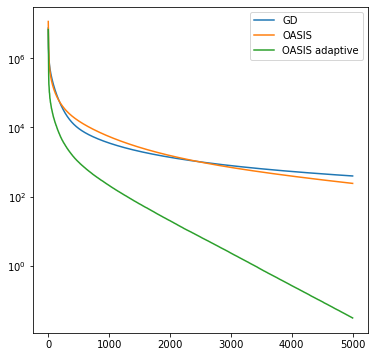

In [743]:
plt.semilogy(loss_gd)
plt.semilogy(loss_o)
plt.semilogy(loss_oa)
#plt.semilogy(loss_cg)

plt.legend(["GD", "OASIS", "OASIS adaptive"])

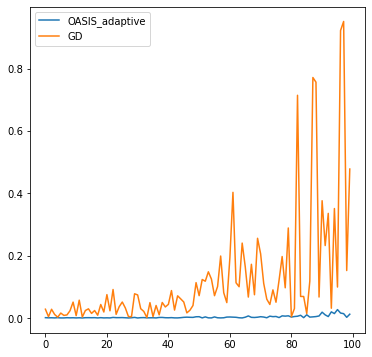

In [744]:
print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

6.915735345502938e-16
5.1909899989599496e-14
0.12347321195501447
0.26122652360418797
0.0031683692017406085


### Stochastic - sum of operators

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [1062]:
n = 100
N = 10

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(1,5,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt
    b.append(bn)
    
    print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [1063]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [1064]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

0.0
0.0
(100,)
(100,)
(100,)
(100,)


In [1065]:
jnp.mean((ops[0]@x0-b)**2)

DeviceArray(1.39627619e+09, dtype=float64)

In [1066]:

F = lambda x : loss_func(x, ops, b)
gradFidx = lambda x, idx : grad_loss_func(x, ops[idx], b[idx])
hvpFidx = lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx])

In [1090]:
N_epoch = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 2, N = N, iter_display = 100)

Epoch 100/1000


100%|██████████| 5/5 [00:00<00:00, 37.50it/s, loss=29545.352]

  Loss =  35410.521


Epoch 200/1000


100%|██████████| 5/5 [00:00<00:00, 35.60it/s, loss=231.950]

  Loss =  306.871


Epoch 300/1000


100%|██████████| 5/5 [00:00<00:00, 34.27it/s, loss=5.842]

  Loss =  7.044


Epoch 400/1000


100%|██████████| 5/5 [00:00<00:00, 35.48it/s, loss=0.204]

  Loss =  0.212


Epoch 500/1000


100%|██████████| 5/5 [00:00<00:00, 35.50it/s, loss=0.008]

  Loss =  0.007


Epoch 600/1000


100%|██████████| 5/5 [00:00<00:00, 34.29it/s, loss=0.000]

  Loss =  0.000


Epoch 700/1000


100%|██████████| 5/5 [00:00<00:00, 34.30it/s, loss=0.000]

  Loss =  0.000


Epoch 800/1000


100%|██████████| 5/5 [00:00<00:00, 33.48it/s, loss=0.000]

  Loss =  0.000


Epoch 900/1000


100%|██████████| 5/5 [00:00<00:00, 33.93it/s, loss=0.000]

  Loss =  0.000


Epoch 1000/1000


100%|██████████| 5/5 [00:00<00:00, 34.40it/s, loss=0.000]

  Loss =  0.000


In [1087]:
N_epoch = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 2, N = N, iter_display = 100)


Epoch 100/1000


100%|██████████| 5/5 [00:00<00:00, 23.87it/s, loss=15.147]


  Loss =  13.565
Epoch 200/1000


100%|██████████| 5/5 [00:00<00:00, 24.86it/s, loss=0.001]


  Loss =  0.001
Epoch 300/1000


100%|██████████| 5/5 [00:00<00:00, 24.13it/s, loss=0.000]


  Loss =  0.000
Epoch 400/1000


100%|██████████| 5/5 [00:00<00:00, 23.39it/s, loss=0.000]


  Loss =  0.000
Epoch 500/1000


100%|██████████| 5/5 [00:00<00:00, 22.54it/s, loss=0.000]


  Loss =  0.000
Epoch 600/1000


100%|██████████| 5/5 [00:00<00:00, 24.06it/s, loss=0.000]


  Loss =  0.000
Epoch 700/1000


100%|██████████| 5/5 [00:00<00:00, 23.89it/s, loss=0.000]


  Loss =  0.000
Epoch 800/1000


100%|██████████| 5/5 [00:00<00:00, 24.49it/s, loss=0.000]


  Loss =  0.000
Epoch 900/1000


100%|██████████| 5/5 [00:00<00:00, 24.76it/s, loss=0.000]


  Loss =  0.000
Epoch 1000/1000


100%|██████████| 5/5 [00:00<00:00, 22.52it/s, loss=0.000]


  Loss =  0.000


In [1091]:
N_epoch = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 100)

Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 38.72it/s, loss=7594733.998]

  Loss =  7594733.998


Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 37.21it/s, loss=1614130.745]

  Loss =  1614130.745


Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00, 29.67it/s, loss=439449.193]

  Loss =  439449.193


Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00, 37.81it/s, loss=133773.589]

  Loss =  133773.589


Epoch 500/1000


100%|██████████| 1/1 [00:00<00:00, 34.13it/s, loss=43790.389]

  Loss =  43790.389


Epoch 600/1000


100%|██████████| 1/1 [00:00<00:00, 34.27it/s, loss=15181.108]

  Loss =  15181.108


Epoch 700/1000


100%|██████████| 1/1 [00:00<00:00, 31.56it/s, loss=5551.918]

  Loss =  5551.918


Epoch 800/1000


100%|██████████| 1/1 [00:00<00:00, 34.24it/s, loss=2138.753]

  Loss =  2138.753


Epoch 900/1000


100%|██████████| 1/1 [00:00<00:00, 38.01it/s, loss=866.373]

  Loss =  866.373


Epoch 1000/1000


100%|██████████| 1/1 [00:00<00:00, 39.88it/s, loss=367.866]

  Loss =  367.866


In [1088]:
N_epoch = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 100)


Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 24.05it/s, loss=3992.607]

  Loss =  3992.607


Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 25.11it/s, loss=9.949]

  Loss =  9.949


Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00, 18.18it/s, loss=0.023]

  Loss =  0.023


Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00, 22.67it/s, loss=0.000]

  Loss =  0.000


Epoch 500/1000


100%|██████████| 1/1 [00:00<00:00, 23.44it/s, loss=0.000]

  Loss =  0.000


Epoch 600/1000


100%|██████████| 1/1 [00:00<00:00, 24.35it/s, loss=0.000]

  Loss =  0.000


Epoch 700/1000


100%|██████████| 1/1 [00:00<00:00, 23.40it/s, loss=0.000]

  Loss =  0.000


Epoch 800/1000


100%|██████████| 1/1 [00:00<00:00, 23.05it/s, loss=0.000]

  Loss =  0.000


Epoch 900/1000


100%|██████████| 1/1 [00:00<00:00, 25.29it/s, loss=0.000]

  Loss =  0.000


Epoch 1000/1000


100%|██████████| 1/1 [00:00<00:00, 25.00it/s, loss=0.000]

  Loss =  0.000


In [1089]:
N_epoch = 1000
beta2 = 0.99
eta = 1e-8
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 2, verbose = True, iter_display = 100)

Epoch 1/1000 

100%|██████████| 5/5 [00:00<00:00, 65.84it/s, grad=4.139e+07, loss=198803574.088]

  |Grad| = 4.583e+07
  Loss = 290057520.441


Epoch 101/1000 

100%|██████████| 5/5 [00:00<00:00, 71.60it/s, grad=5.694e+04, loss=7250.281]

  |Grad| = 8.866e+04
  Loss = 9128.105


Epoch 201/1000 

100%|██████████| 5/5 [00:00<00:00, 59.57it/s, grad=7.279e+03, loss=44.970]

  |Grad| = 6.568e+03
  Loss = 38.239


Epoch 301/1000 

100%|██████████| 5/5 [00:00<00:00, 60.35it/s, grad=6.200e+02, loss=0.314]

  |Grad| = 5.888e+02
  Loss = 0.293


Epoch 401/1000 

100%|██████████| 5/5 [00:00<00:00, 66.09it/s, grad=5.944e+01, loss=0.003]

  |Grad| = 5.231e+01
  Loss = 0.003


Epoch 501/1000 

100%|██████████| 5/5 [00:00<00:00, 68.64it/s, grad=6.448e+00, loss=0.000]

  |Grad| = 5.825e+00
  Loss = 0.000


Epoch 601/1000 

100%|██████████| 5/5 [00:00<00:00, 62.62it/s, grad=8.165e-01, loss=0.000]

  |Grad| = 6.473e-01
  Loss = 0.000


Epoch 701/1000 

100%|██████████| 5/5 [00:00<00:00, 64.50it/s, grad=5.664e-02, loss=0.000]

  |Grad| = 5.676e-02
  Loss = 0.000


Epoch 801/1000 

100%|██████████| 5/5 [00:00<00:00, 66.78it/s, grad=8.061e-03, loss=0.000]

  |Grad| = 6.822e-03
  Loss = 0.000


Epoch 901/1000 

100%|██████████| 5/5 [00:00<00:00, 59.08it/s, grad=8.560e-04, loss=0.000]

  |Grad| = 6.592e-04
  Loss = 0.000


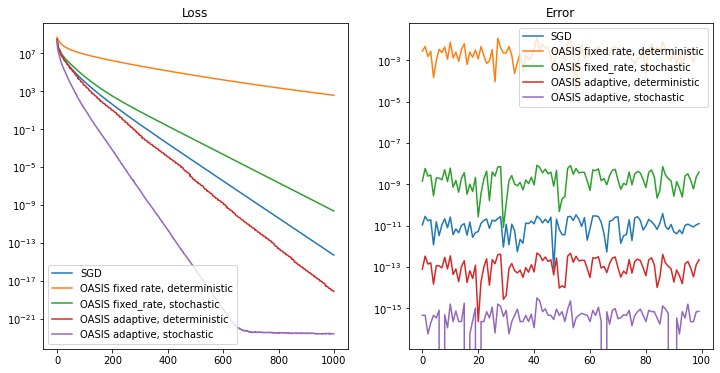

In [1092]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* Run the other deterministic algorithms to this toy problem too (Newton and CG) or maybe not
* Run the new OASIS algorithms on the old (deterministic one operator) toy problem 
* ~~Implement the adaptive version of the stochastic OASIS~~